In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import string
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, accuracy_score

import emoji
import missingno as msno
import plotly_express as px
from wordcloud import WordCloud
from matplotlib import pyplot as plt

# Data Exploration

In [2]:
df = pd.read_csv("/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv")
df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


The tweets have the following categories:
1. not_cyberbullying
2. gender
3. religion
4. age
5. etnicity
6. other_cyberbullying

In [3]:
df.describe()

,tweet_text,cyberbullying_type
count,47692,47692
unique,46017,6
top,RT @sailorhg: the intro for my hardware hackin...,religion
freq,2,7998


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [5]:
df.cyberbullying_type.unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

# Remove duplicates

In [6]:
df.duplicated().sum()

36

In [7]:
df = df.drop_duplicates()
df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


# Explore cyberbullying categories

Text(0.5, 1.0, 'Tweets distribution by cyberbullying types')

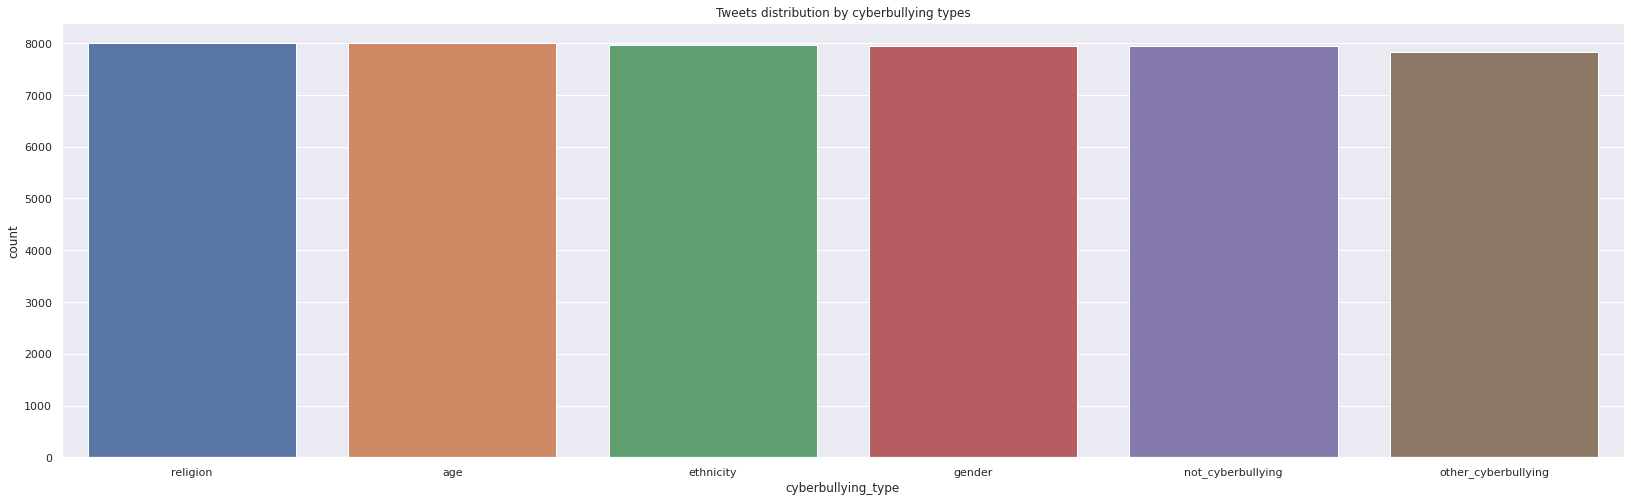

In [8]:
sns.set(rc={'figure.figsize':(28,8)})
sns.countplot(x="cyberbullying_type", data=df, order=df.cyberbullying_type.value_counts().index).set_title("Tweets distribution by cyberbullying types")

In [9]:
(df.cyberbullying_type.value_counts(normalize=True) * 100)

religion               16.780678
age                    16.770186
ethnicity              16.700940
gender                 16.677858
not_cyberbullying      16.654776
other_cyberbullying    16.415562
Name: cyberbullying_type, dtype: float64

# Data Preprocessing

Clean text by removing punctuation, numbers and extra spaces, removing stop words, and lemmatization:

In [10]:
def initial_cleaning(text):
    text = re.sub(r"^RT[\s]+","",text)
    text = text.lower()
    text = re.sub(r"https?:\/\/.*[\r\n]*","https",text)
    text = re.sub(r"@[A-Za-z0-9]+","",text)
    text = re.sub(emoji.get_emoji_regexp(),r" ",text)
    text = re.sub(r'[0-9]',' ',text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)
    return text

def remove_stopword(text):
    a = [i for i in text.split() if i not in stopwords.words('english')]
    return ' '.join(a)

porter = PorterStemmer()
def stem(text):
    a = [porter.stem(i) for i in text.split()]
    return ' '.join(a)

wl = WordNetLemmatizer()
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

tokenizer = TweetTokenizer(preserve_case=False, 
                           strip_handles=True,
                           reduce_len=True)
def lemmatizer(text):
    word_pos_tags = nltk.pos_tag(tokenizer.tokenize(text))
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    return " ".join(a)

In [11]:
def text_preprocessing(text):
    return lemmatizer(stem(remove_stopword(initial_cleaning(text))))

df["original_tweet"] = df.tweet_text
df.tweet_text = df.tweet_text.apply(lambda x: text_preprocessing(x))
df

,tweet_text,cyberbullying_type,original_tweet
0,word katandandr food crapilici mkr,not_cyberbullying,"In other words #katandandre, your food was cra..."
1,aussietv white mkr theblock imacelebrityau tod...,not_cyberbullying,Why is #aussietv so white? #MKR #theblock #ImA...
2,classi whore red velvet cupcak,not_cyberbullying,@XochitlSuckkks a classy whore? Or more red ve...
3,gio meh p thank head concern anoth angri dude ...,not_cyberbullying,"@Jason_Gio meh. :P thanks for the heads up, b..."
4,isi account pretend kurdish account like islam...,not_cyberbullying,@RudhoeEnglish This is an ISIS account pretend...
...,...,...,...
47687,black ppl expect anyth depend anyth yet free p...,ethnicity,"Black ppl aren't expected to do anything, depe..."
47688,turner withhold disappoint turner call court “...,ethnicity,Turner did not withhold his disappointment. Tu...
47689,swear god dumb nigger bitch get bleach hair re...,ethnicity,I swear to God. This dumb nigger bitch. I have...
47690,yea fuck rt your nigger fuck unfollow fuck dum...,ethnicity,Yea fuck you RT @therealexel: IF YOURE A NIGGE...


# Tweet length visualization

In [12]:
df["tweet_length"] = df.tweet_text.map(lambda x: len(x))
tweet_length_stats = df[["cyberbullying_type", "tweet_length"]].groupby("cyberbullying_type").mean()
tweet_length_stats["min"] = df[["cyberbullying_type", "tweet_length"]].groupby("cyberbullying_type").min().tweet_length
tweet_length_stats["max"] = df[["cyberbullying_type", "tweet_length"]].groupby("cyberbullying_type").max().tweet_length
tweet_length_stats

,tweet_length,min,max
cyberbullying_type,,,
age,99.044920,4,863
ethnicity,82.116346,3,1064
gender,75.231505,0,738
not_cyberbullying,42.456470,0,893
other_cyberbullying,40.124121,0,2350
religion,111.571964,4,260


In [13]:
px.histogram(df[df["tweet_length"] < 1000], x="tweet_length", color="cyberbullying_type", title="Twitters Length Distribution Plot")

In [14]:
df

,tweet_text,cyberbullying_type,original_tweet,tweet_length
0,word katandandr food crapilici mkr,not_cyberbullying,"In other words #katandandre, your food was cra...",34
1,aussietv white mkr theblock imacelebrityau tod...,not_cyberbullying,Why is #aussietv so white? #MKR #theblock #ImA...,90
2,classi whore red velvet cupcak,not_cyberbullying,@XochitlSuckkks a classy whore? Or more red ve...,30
3,gio meh p thank head concern anoth angri dude ...,not_cyberbullying,"@Jason_Gio meh. :P thanks for the heads up, b...",53
4,isi account pretend kurdish account like islam...,not_cyberbullying,@RudhoeEnglish This is an ISIS account pretend...,50
...,...,...,...,...
47687,black ppl expect anyth depend anyth yet free p...,ethnicity,"Black ppl aren't expected to do anything, depe...",125
47688,turner withhold disappoint turner call court “...,ethnicity,Turner did not withhold his disappointment. Tu...,182
47689,swear god dumb nigger bitch get bleach hair re...,ethnicity,I swear to God. This dumb nigger bitch. I have...,70
47690,yea fuck rt your nigger fuck unfollow fuck dum...,ethnicity,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,54


# Tweet content visualization

In [15]:
def display_word_cloud(field_name, title):
    words = df[df['cyberbullying_type'] == field_name].tweet_text
    cloud = WordCloud(background_color='black', width=2000, height=1000, colormap="viridis", collocations=False).generate(" ".join(words))
    plt.axis('off')
    plt.title(title,fontsize=40)
    plt.imshow(cloud)

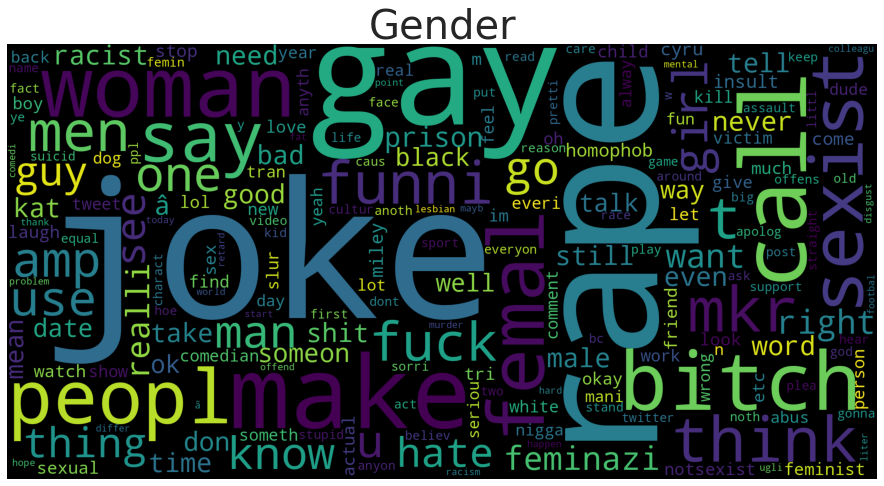

In [16]:
display_word_cloud("gender", "Gender")

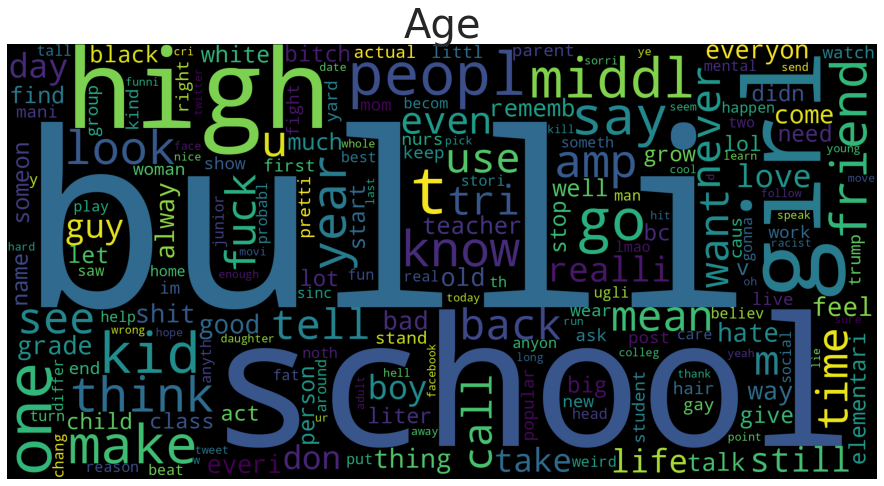

In [17]:
display_word_cloud("age", "Age")

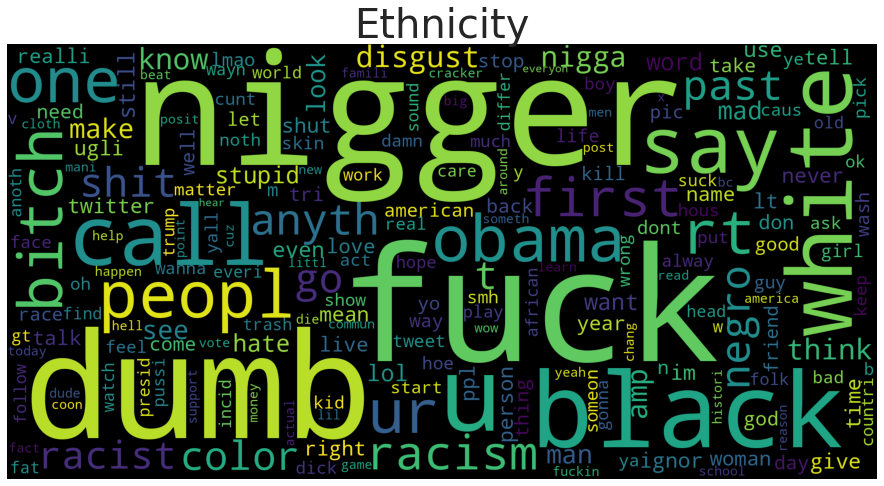

In [18]:
display_word_cloud("ethnicity", "Ethnicity")

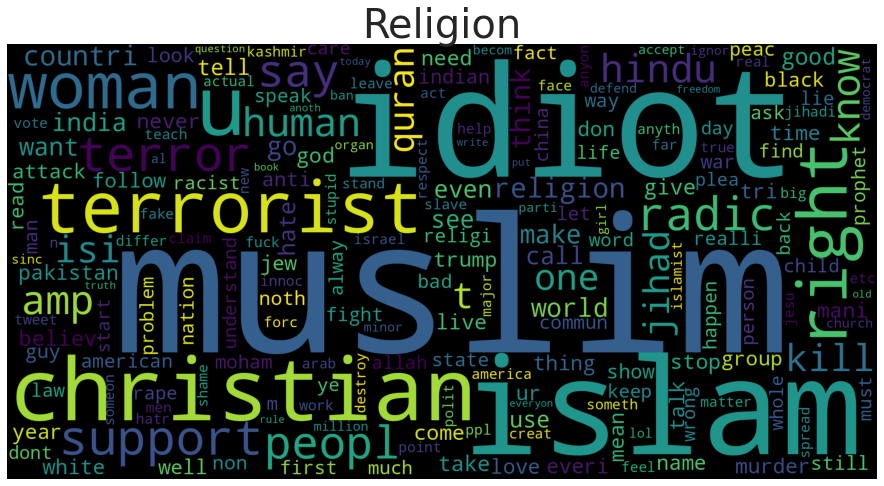

In [19]:
display_word_cloud("religion", "Religion")

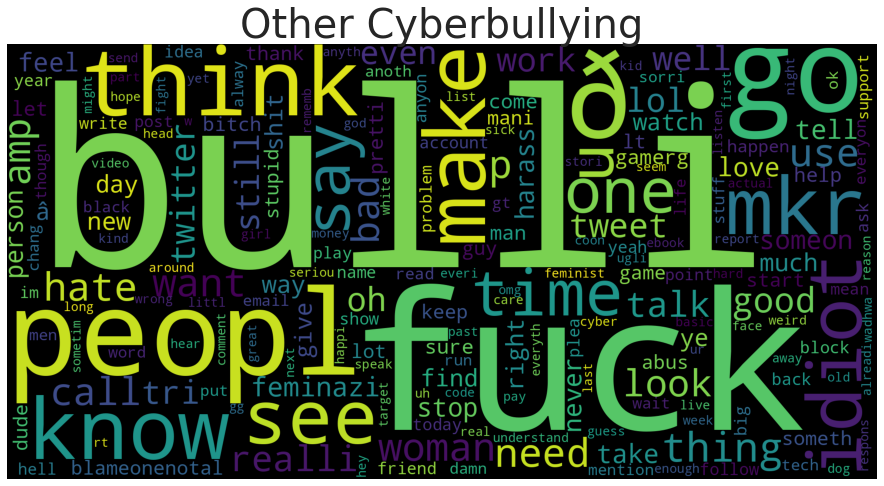

In [20]:
display_word_cloud("other_cyberbullying", "Other Cyberbullying")

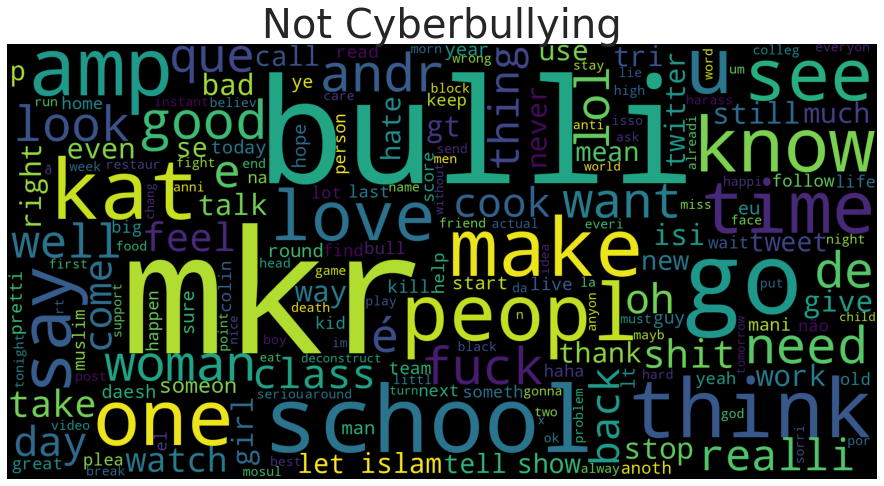

In [21]:
display_word_cloud("not_cyberbullying", "Not Cyberbullying")

# Classification Model

Convert text into vectors using Word2Vec dictionary:

In [22]:
from gensim.models import Word2Vec

class MeanEmbeddingVectorizer():
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))

    def transform(self, X):
        return np.array([np.mean([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0) for words in X])
    
    def fit(self, X, y):
        return self

df["tokenized"] = [tokenizer.tokenize(i) for i in df['tweet_text']]
model = Word2Vec(df["tokenized"], min_count=1)
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors)) 
modelw = MeanEmbeddingVectorizer(w2v)

In [23]:
df["cyberbullying_type_code"] = df.cyberbullying_type.astype('category').cat.codes
df["cyberbullying_type_code"].unique()

array([3, 2, 5, 4, 0, 1], dtype=int8)

Let's split the data with validating all cyberbullying types are represented in both test and train sets (using **stratify** parameter):

In [24]:
# Split to train and test sets
X_train, X_test, y_train, y_test = train_test_split(df["tokenized"],df["cyberbullying_type_code"],test_size=0.2,shuffle=True, stratify=df["cyberbullying_type"])

# Convert train and test sets to vectors
X_train_vectors_w2v = modelw.transform(X_train)
X_test_vectors_w2v = modelw.transform(X_test)

Let's use XGBoost for this classification, as is a state-of-the-art algorithm in many classification problems. I used GridSearchCV to perform hyparameter tuning.

In [25]:
from xgboost import XGBClassifier

model = XGBClassifier(
    use_label_encoder=False,
    max_depth=4,
    min_child_weight=2,
    gamma=0.3,
    subsample=0.7,
    colsample_bytree=0.6,
    reg_alpha=0.1
)
model.fit(X_train_vectors_w2v, y_train)

[16:31:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, gamma=0.3, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0.1, reg_lambda=1, scale_pos_weight=None, subsample=0.7,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [26]:
predictions = model.predict(X_test_vectors_w2v)
print(f"Accuracy: {accuracy_score(y_test, predictions)}")
print(classification_report(y_test, predictions))

Accuracy: 0.795216114141838
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1598
           1       0.92      0.94      0.93      1592
           2       0.87      0.79      0.83      1590
           3       0.59      0.50      0.54      1587
           4       0.55      0.67      0.60      1565
           5       0.90      0.92      0.91      1600

    accuracy                           0.80      9532
   macro avg       0.80      0.79      0.79      9532
weighted avg       0.80      0.80      0.79      9532

